<a href="https://colab.research.google.com/github/AdarshShah/illumNet/blob/main/ImageEnhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Approach to Image Enhancement using Low Light Net (LLNet)
Adarsh Shah, MTech (A.I.)

[adarshshah@iisc.ac.in](adarshshah@iisc.ac.in)

[LLNet](https://www.sciencedirect.com/science/article/pii/S003132031630125X?casa_token=iWWVnisqhCkAAAAA:j5fneY7SDdkzJ2okhWA2N807cXYg57fY4CIpCbAD2tESbw2Mwf9buVbuJwCphbaphLiTTig-ioU:)




In [1]:
import numpy as np

from skimage import img_as_float
from skimage.io import imread_collection, imread, imsave
from skimage.transform import resize
from skimage.metrics import structural_similarity
from skimage.color import rgb2hsv, hsv2rgb

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.activations import relu
from tensorflow.keras.metrics import mean_squared_error

from matplotlib import pyplot as plt

In [17]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [18]:
physical_devices = list(tf.config.experimental.list_physical_devices('GPU'))
for gpu in physical_devices:
  print(gpu)
  tf.config.experimental.set_memory_growth(gpu,True)

In [16]:
list(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### 1.0 Data Preparation

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gujjugodfather/imageenhancement

In [ ]:
! unzip imageenhancement.zip

In [20]:
data = imread_collection(['./dped/dped/iphone/training_data/iphone/*'],conserve_memory=False)
xtrain = list()
for i,file in enumerate(data.files[:20000]):
  xtrain.append(rgb2hsv(img_as_float(data.load_func(file))))

In [21]:
data = imread_collection(['./dped/dped/iphone/training_data/canon/*'],conserve_memory=False)
ytrain = list()
for i,file in enumerate(data.files[:20000]):
  ytrain.append(rgb2hsv(img_as_float(data.load_func(file))))

In [22]:
data = imread_collection(['./dped/dped/iphone/test_data/patches/iphone/*'],conserve_memory=False)
xtest = list()
for i,file in enumerate(data.files[:2000]):
  xtest.append(rgb2hsv(img_as_float(data.load_func(file))))

In [23]:
data = imread_collection(['./dped/dped/iphone/test_data/patches/canon/*'],conserve_memory=False)
ytest = list()
for i,file in enumerate(data.files[:2000]):
  ytest.append(rgb2hsv(img_as_float(data.load_func(file))))

In [24]:
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)
xtest = np.array(xtest)
ytest = np.array(ytest)

In [25]:
Xt = xtrain[:,:,:,2]
Yt = ytrain[:,:,:,2]
Xtest = xtest[:,:,:,2]
Ytest = ytest[:,:,:,2]

### 2.0 SSDA based auto encoder

In [39]:
x = Input(shape=(100,100,3))

layer11 = Conv2D(filters=128,kernel_size=(7,7),strides=(1,1),padding='same',activation=relu)(x)
layer12 = Conv2D(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer11)
layer13 = Conv2D(filters=16,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer12)

layer16 = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer13)
layer17 = Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer16)
layer18 = Conv2DTranspose(filters=3,kernel_size=(7,7),strides=(1,1),padding='same',activation=relu)(layer17)

layer21 = Conv2D(filters=128,kernel_size=(7,7),strides=(1,1),padding='same',activation=relu)(layer18)
layer22 = Conv2D(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer21)
layer23 = Conv2D(filters=16,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer22)

layer26 = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer23)
layer27 = Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer26)
layer28 = Conv2DTranspose(filters=1,kernel_size=(7,7),strides=(1,1),padding='same',activation='sigmoid')(layer27)

'''
layer31 = Conv2D(filters=128,kernel_size=(7,7),strides=(1,1),padding='same',activation=relu)(layer28)
layer32 = Conv2D(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer31)
layer33 = Conv2D(filters=16,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer32)

layer36 = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer33)
layer37 = Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2,2),padding='same',activation=relu)(layer36)
layer38 = Conv2DTranspose(filters=1,kernel_size=(7,7),strides=(1,1),padding='same',activation=relu)(layer37)
'''
y = Reshape((100,100,1))(layer28)

In [40]:
llnet = Model(x,y)
llnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 128)     18944     
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 32)        36896     
                                                                 
 conv2d_20 (Conv2D)          (None, 25, 25, 16)        4624      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 50, 50, 32)       4640      
 Transpose)                                                      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 100, 100, 128)    36992     
 Transpose)                                                

In [41]:
def myloss(im1,im2):
  return 1-tf.image.ssim(im1,im2,1)

llnet.compile(optimizer=Adam(),loss=mean_squared_error,metrics=[mean_squared_error])

In [42]:
llnet.fit(x=xtrain,y=Yt,validation_data=(xtest,Ytest),batch_size=32,epochs=1)

625/625 [==============================] - 649s 1s/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0165 - val_mean_squared_error: 0.0165


### 3.0 Evaluation

Using Structural Similarity Index

In [69]:
ypredict = llnet.predict(Ytest)

In [71]:
ypredict.shape

(2000, 100, 100, 1)

In [ ]:
sum = 0
for a,b in zip(ypredict,Ytest):
    sum += structural_similarity(np.reshape(a,(100,100)),np.reshape(b,(100,100)))
sum /= len(Ytest)
print(sum)

In [ ]:
i = np.random.randint(len(ytest))
plt.subplot(131)
plt.imshow(hsv2rgb(xtest[i]),'brg')
plt.subplot(132)
plt.imshow(hsv2rgb(ytest[i]),'brg')
plt.subplot(133)
img = xtest[i]
img[:,:,2] = np.reshape(ypredict[i],(100,100))
plt.imshow(hsv2rgb(img),'brg')
plt.show()
plt.clf()

### 4.0 Test on Real Images

In [30]:
data = imread_collection(['./dped/dped/iphone/test_data/full_size_test_images/*'],conserve_memory=False)

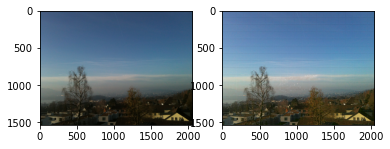

<Figure size 432x288 with 0 Axes>

In [43]:
I = np.random.randint(len(data.files))
image = imread(data.files[I])

image = rgb2hsv(img_as_float(image))

plt.subplot(121)
plt.imshow(hsv2rgb(image),'brg')

P,Q,_ = image.shape
P_n = P + 100 - P%100
Q_n = Q + 100 - Q%100

image = resize(image,(P_n,Q_n))

for i in range(P_n//100):
    for j in range(Q_n//100):
        illum = image[100*i:100*(i+1),100*j:100*(j+1),:]
        illum = np.reshape(illum,(1,100,100,3))
        illum = llnet.predict(illum)
        illum = np.reshape(illum,(100,100))
        image[100*i:100*(i+1),100*j:100*(j+1),2] = illum



image = resize(image,(P,Q))
plt.subplot(122)
plt.imshow(hsv2rgb(image),'brg')
plt.show()
plt.clf()